# ANN Training and Validation

This exercise is split into two different parts, first you will be implementing and training a 2-layer neural network using a high level library, [pytorch](https://pytorch.org/). Secondly you will implement the neural network, the forward pass and the backward pass from scratch using numpy. The data which will be used is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which contains handwritten numbers from 0-9. Examples can be seen in the image below.

![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Literature
Before starting with the implementation you should familiarize yourself with relevant sections from the [deep learning book](https://www.deeplearningbook.org/). This will help you understand the theory behind neural networks and what mathematical formulas are important for the task. The lectures has touched on most of these concepts too. Below you can find a list of recommended sections from the book. If you feel that you are already familiar with the contents of the section, feel free to skip it.

* Chapter 5 - Machine learning basics
    - Section 5.1 - Explains the basics of what we mean by learning and what supervised learning is.
    - Section 5.2 - Talks about generalization, the generalization gap and under/overfitting.
    - Section 5.3 - Validation and validation set.
* Chapter 6 - Deep feedforward networks
    - Section 6.0 - Discusses what do we mean by feedfoward networks and terminology such as input layer, output layer and hidden layer.
    - Section 6.2 - Discusses what gradient based learning is and what cost functions are.
    - Section 6.5 - Explains back-propagation. Important here are the formulas 6.49 - 6.52.
    
## Examination

### Part 1
* Implementation of a 2 layer NN (very similar to ex0)
* Training of this 2 layer NN (once again, very similar to ex0)
* Validation of the network during training
    - Save the model which performs the best on the validation data
* Graph the training loss vs validation loss
* At least 85% accuracy on the validation data (remember to load the best performing model before performing the accuracy test)

### Part 2
* Implementation of a 2 layer NN using numpy
* Training and validation of the 2 layer NN
    - Once again, save the best performing model (can be done in memory)
* Graph the training vs validation loss
* At least 50% accuracy on the validation data (can be hard to get high accuracy)

# Part 1

## MNIST dataset preparation
We will start by downloading and preparing the data such that it is usable for our purposes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import copy

Dataset information
Training set size: 60000
Validation set size: 10000
Dataset sample:


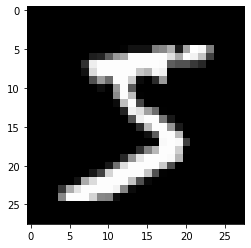

In [2]:
# Define the mini-batch size
batch_size = 1000

# Define how many epochs we want the training to be
epochs = 15

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

mnist_validation = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)

print("Dataset information")
print(f"Training set size: {len(mnist_train)}")
print(f"Validation set size: {len(mnist_validation)}")

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

print("Dataset sample:")
images, labels = next(iter(train_loader))
plot_digit(images[0])

## Implement a classifier using pytorch

Given the code above, your knowledge from the literature, lectures and exercise 0. Implement a 2 layer neural network using pytorch. This network should be capable of being trained and validated. The weights of the model which performs the best on the validation data should be stored to make it easy to use them. You are free to choose any optimizer and loss function. Just note that some loss functions require the labels to be 1 hot encoded. **As you will not use convolutional layers (later in the course), the input needs to be changed to a 1d tensor (see [view](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)).**

In [3]:
# Setup network
# Config
LR = 0.1

# Create the 2-layer NN
network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

# Init optimizer
optimizer = optim.SGD(network.parameters(), lr=LR)

# Init loss function
loss_fn = nn.MSELoss()

to_onehot = nn.Embedding(10, 10) 
to_onehot.weight.data = torch.eye(10)

Example output:


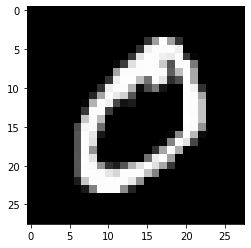

Actual: 0 - Prediction: 6


In [4]:
# Prints the input image along with the prediction result
def predict_img(image, index):
    plot_digit(image)
    
    input_tensor = image.view(1, 784)
    prediction = network(input_tensor)
    guess = torch.argmax(prediction[0], dim=-1)
    print(f"Actual: {labels[index].item()} - Prediction: {guess.item()}")

print("Example output:")
predict_img(images[1], 1)

In [5]:
# Predicts on validation set and returns the validation loss
def validate():
    # Predict on each batch of the validation set
    for batch, (images, labels) in enumerate(validation_loader):
        images = images.view(-1, 784)
        labels = to_onehot(labels)
        
        prediction = network(images)
        
        loss = loss_fn(prediction, labels)
        
    return loss.item()

In [6]:
# Training of the network, after each 
def training():
    train_losses = []
    validation_losses = []
    lowest_loss = 100 # keep track of lowest loss model during training

    # Train on the training set
    for epoch in range(epochs):
        for batch, (images, labels) in enumerate(train_loader):
            # Transform labels to one-hot
            labels = to_onehot(labels)

            # Reshape input images to single 784 vector
            images = images.view(-1, 784)

            prediction = network(images)

            loss = loss_fn(prediction, labels)
            
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()


            # Print the epoch, batch, and loss
            print(
                '\rEpoch {} [{}/{}] - Loss: {}'.format(
                    epoch+1, batch+1, len(train_loader), loss
                ),
                end=''
            )
    
        # save the current epochs training and validation loss
        train_losses.append(loss.item())
        val_loss = validate()
        validation_losses.append(val_loss)
        
        # Check if validation loss is the best so far
        if (val_loss < lowest_loss):
            lowest_loss = val_loss
            best_model = copy.deepcopy(network)

    # plot the losses during training
    plt.plot(range(1, epochs + 1), train_losses, label="Training")
    plt.plot(range(1, epochs + 1), validation_losses, label="Validation")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return best_model

In [7]:
# Predicts on validation set (validation set is the same as test set)
# using the model and returns the accuracy
def test_accuracy(model):
    correct = 0
    # Predict on each batch of the validation set
    for batch, (images, labels) in enumerate(validation_loader):
        images = images.view(-1, 784)
        predictions = model(images)
        
        # Collect the prediction result for each image in the batch
        for i in range(len(images)):
            guess = torch.argmax(predictions[i], dim=-1)
            if (guess.item() == labels[i]):
                correct += 1
    
    # return accuracy
    return correct / len(mnist_validation)

Pre-trained: Accuracy=0.0924
Epoch 15 [60/60] - Loss: 0.026514273136854172

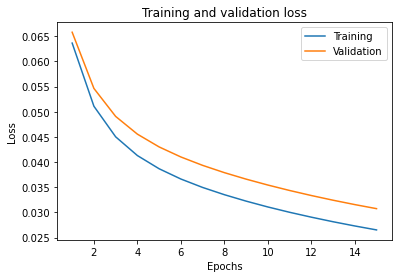

In [8]:
# Train and validate
pre_accuracy = test_accuracy(network)
print(f"Pre-trained: Accuracy={pre_accuracy}")
best_model = training()

In [9]:
# Calculate accuracy on validation set using the best model found during training and validation
best_model_accuracy = test_accuracy(best_model)
final_model_accuracy = test_accuracy(network)
print(f"Best model found: Accuracy={best_model_accuracy}")
print(f"Model after training: Accuracy={final_model_accuracy}")

Best model found: Accuracy=0.8896
Model after training: Accuracy=0.8896



# Part 2

## Implement a classifier using numpy
Implement a similar 2 layer neural network, without using a high-level machine learning library like pytorch. It should function the same as the network in task 1. The code block below contains code to change the training data from the DataLoader format to the "raw" numpy format. It also contains some comments to guide you in the right direction. **Please note that this solution should not "scale" hence it is 100% OK to just have two weight matrices variables.**

### The foward pass
This is easy. Recall that each differnt layer is calculated by the formula: 
$$ y = g(\mathbf{W}*\mathbf{x} + b) $$
where $W$ is the weight matrix, $x$ the input, $b$ the bias and $g$ the non-linearity. For this exercise you are allowed to put $b = 0$ for simplicity when calculating the backwards pass.

### Backward pass
This can be tricky. In canvas there is supplementary material which explains back propogation and all the maths behind it. It should be under Extra material > Summary - Backpropagation.pdf. This together with the course book should be enough material for you to be able to implement the training algorithm.

### Weight update
Once you have calculated the gradient of both weight matrixes, this is updated by:
$$ W_i = W_i - \gamma \dfrac{dL}{dW_i} $$
where $\gamma$ is the step size, or learning rate.

Epoch 15 [60/60] - Loss: 0.066718789817702365

One validation batch (best preforming model):
Accuracy = 0.523 (total=1000, correct=523)


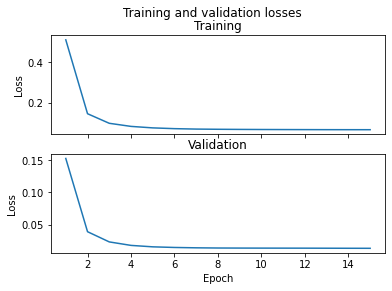

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys

D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate

# Define network with one hidden layer, random initial weights
w1 = np.random.randn(D_in, H1)
w2 = np.random.randn(H1, D_out)

# Training iterations
# load a batch
train_losses = []
val_losses = []
lowest_loss = 100
best_model = (w1, w2)
for epoch in range(epochs):
    # Train (for each batch)
    batch=0
    for inputs, labels in train_loader:
        batch +=1
        inputs = inputs.numpy()
        labels = labels.numpy()
        
        # Predict on each sample in the mini-batch
        for i in range(batch_size):
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]] # 1-hot encoding

            # Forward pass
            h = x.dot(w1)
            h_relu = np.maximum(np.zeros((1, H1)), h)
            y_pred = h_relu.dot(w2)

            # Compute loss function, squared error
            loss = (y_pred - y) ** 2
            
            
            # Compute gradients of square-error loss with respect to w1 and w2 using backpropagation
            grad_h = np.where(h_relu > 0, 1, 0) # derivative of h_relu
            grad_loss = 2 * (y_pred - y)
            
            # dL/dw2: gradient of the loss with respect to w2
            grad_w2 = h_relu.T.dot(grad_loss)

            # dL/dw1: gradient of the loss with respect to w1
            grad_loss_w2 = grad_loss.dot(w2.T)
            grad_h_loss_w2 = grad_h * grad_loss_w2
            grad_w1 = x.T.dot(grad_h_loss_w2)
            #dL_dw1 = np.dot(x.transpose(), np.multiply(h_relu_prime, np.dot(loss_prime, w2.transpose())))

            # Update weights (minibatch stochastic gradient descent)
            # we update for each prediction not after each minibatch
            w1 -= gamma * grad_w1
            w2 -= gamma * grad_w2
            
        # Print the epoch, batch, and loss
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, batch, len(train_loader), loss.mean()
            ),
            end=''
        )
    # store epoch last loss
    train_losses.append(loss.mean()) # store MSE for plotting
    
    # Validate the model
    for inputs, labels in validation_loader:
        inputs = inputs.numpy()
        labels = labels.numpy()
        # predict for each sample in batch
        for i in range(batch_size):
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]] # 1-hot encoding

            # predict
            h = x.dot(w1)
            h_relu = np.maximum(np.zeros((1, H1)), h)
            y_pred = h_relu.dot(w2)
            
            # Compute loss
            loss = (y_pred - y) ** 2
            
    # Store the model (weights) of the best performing model
    if (loss.mean() < lowest_loss):
        best_model = (w1, w2)
        lowest_loss = loss.mean()
    
    val_losses.append(loss.mean()) # store MSE for plotting

total = 0
correct = 0

# Test the network against 1 validation batch
(w1, w2) = best_model # load best model
for inputs, labels in validation_loader:
    inputs = inputs.numpy()
    labels = labels.numpy()

    # predict for each sample in batch
    for i in range(batch_size):
        x = inputs[i].reshape((1, D_in))
        
        # predict
        h = x.dot(w1)
        h_relu = np.maximum(np.zeros((1, H1)), h)
        y_pred = h_relu.dot(w2)

        guess = np.argmax(y_pred)
        if guess == labels[i]:
            correct += 1
        total += 1
    break

# Plot training and validation loss
# We decided to plot the loss of the last prediction of each
# epoch (graph was too cluttered when plotting each prediction loss)
fig, (plt_train, plt_val) = plt.subplots(2)
fig.suptitle("Training and validation losses")
plt_train.plot(range(1, epochs + 1), train_losses)
plt_train.set_title("Training")
plt_train.set(xlabel="Epoch", ylabel="Loss")
plt_train.label_outer()
plt_val.plot(range(1, epochs + 1), val_losses)
plt_val.set_title("Validation")
plt_val.set(xlabel="Epoch", ylabel="Loss")
plt_val.label_outer()


# Calculate accuracy on one validation batch with best preforming model
print(f"\n\nOne validation batch (best preforming model):\nAccuracy = {correct/total} (total={total}, correct={correct})")

# Optional task
You have now implemented a 2-layer neural network from scratch. Use this new gained knowledge to create an implementation where you can create and train any sized network. This means that you should be able to specify the structure of the network and then train it using back-propagation.